
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Validation of the synthetic waves and level

inputs required: 
  * historical wave conditions
  * emulator output - synthetic wave conditions
  
in this notebook:
  * Validation of the extreme distributions
  * Analysis of the DWT resposible of extreme TWL events (from the historical and synthetic datasets)
  


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.extremes import Peaks_Over_Threshold as POT
from teslakit.util.time_operations import xds_reindex_daily

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation
from teslakit.plotting.estela import Plot_DWTs_Probs
from teslakit.plotting.wts import Plot_Probs_WT_WT
from teslakit.plotting.outputs import Plot_LevelVariables_Histograms



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/laurac/Dropbox/Majuro_training/teslakit/DATA'
db = Database(p_data)

# set site
db.SetSite('MAJURO-training')


In [3]:
## There is station.nc file in data/historical/offshore that needs to be removed
# --------------------------------------
# Load complete hourly data for extremes analysis

# Historical
HIST_C_h = db.Load_HIST_OFFSHORE(decode_times=True)


In [4]:
# Simulation
SIM_C_h = db.Load_SIM_OFFSHORE_all(decode_times=False)

In [5]:
h=xr.open_dataset('/Users/laurac/Dropbox/Majuro_training/teslakit/DATA/sites/MAJURO-training/SIMULATION/OFFSHORE/00000000/Hs.nc')
time=h.time.values
SIM_C_h['time']=('time',time)
SIM_C_h.to_netcdf(op.join(p_data, 'sites' ,'MAJURO-training','Simulated_hourly_values.nc'))
SIM_C_h

<xarray.Dataset>
Dimensions:     (n_sim: 2, time: 8765832)
Coordinates:
  * time        (time) object 2000-01-01 00:00:00 ... 2999-12-31 23:00:00.13
  * n_sim       (n_sim) int64 0 1
Data variables:
    SS          (time, n_sim) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    msl         (time, n_sim) float64 1.009e+05 1.012e+05 ... 1.009e+05
    MJO         (time, n_sim) float64 23.0 23.0 23.0 23.0 ... 23.0 18.0 23.0
    level       (time, n_sim) float64 0.0001057 7.647e-05 ... 4.737e-05
    wind_dir    (time, n_sim) float64 65.8 56.75 65.8 ... 79.81 203.3 79.81
    TWL         (time, n_sim) float64 0.6482 0.4971 0.6463 ... 0.4655 0.4693
    AWT         (time, n_sim) float64 3.0 3.0 3.0 3.0 3.0 ... 4.0 6.0 4.0 6.0
    AWL         (time, n_sim) float64 0.6481 0.497 0.6462 ... 0.4655 0.4693
    max_storms  (time, n_sim) float64 1.0 1.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    MMSL        (time, n_sim) float64 0.0001054 7.618e-05 ... 3.212e-05 4.8e-05
    Dir         (time, n_sim) float64 62.97 87.74 62.97 ... 82.35 111.1 82.35
    DWT         (time, n_sim) float64 18.0 18.0 18.0 18.0 ... 10.0 34.0 10.0
    wind_speed  (time, n_sim) float64 4.053 8.313 4.053 ... 2.054 7.157 2.054
    AT          (time, n_sim) float64 2.967e-07 2.967e-07 ... -6.309e-07
    Tp          (time, n_sim) float64 9.51 8.957 9.51 ... 10.79 8.612 10.79
    Hs          (time, n_sim) float64 2.515 1.668 2.501 ... 1.042 1.582 1.025

In [6]:
# def. some auxiliar function to select all dataset variables at vn max by groups

def grouped_max(ds, vn=None, dim=None):
    return ds.isel(**{dim: ds[vn].argmax(dim)})



## AWL - Annual Maxima Calculation

In [7]:
# Historical AWL Annual Maxima

# remove nans before and after AWL
ix_nonan = np.squeeze(np.argwhere(~np.isnan(HIST_C_h['AWL'].values[:])))
HIST_C_nonan = HIST_C_h.isel(time = ix_nonan)

# calculate AWL annual maxima dataset
hist_AMax = HIST_C_nonan.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')


In [8]:
# Simulation AWL Annual Maxima

# calculate AWL annual maxima dataset
sim_AMax = SIM_C_h.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')



## AWL - Annual Maxima Return Period

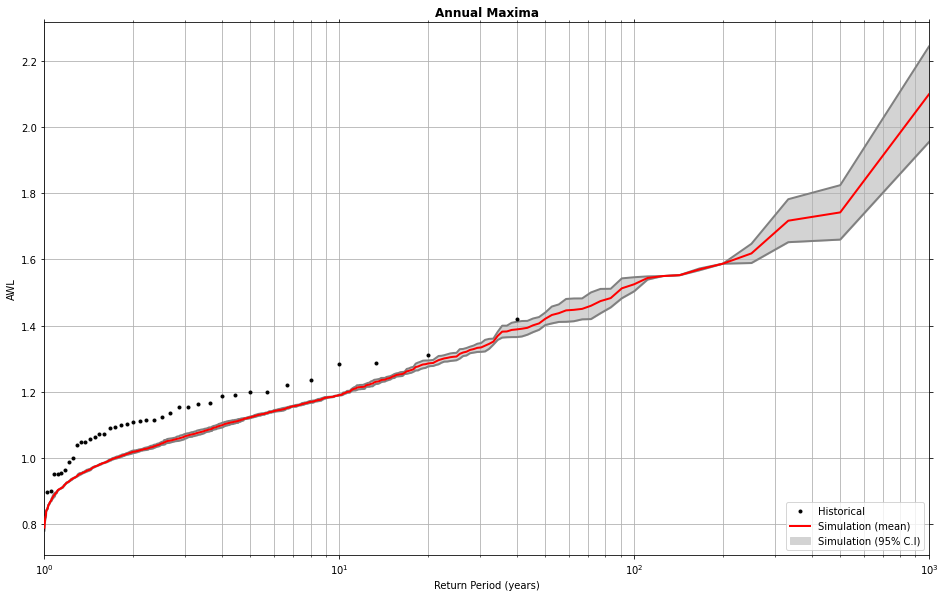

In [9]:
# AWL Annual Maxima Return Period (historical vs. simulations)

Plot_ReturnPeriodValidation(hist_AMax['AWL'], sim_AMax['AWL'].transpose());


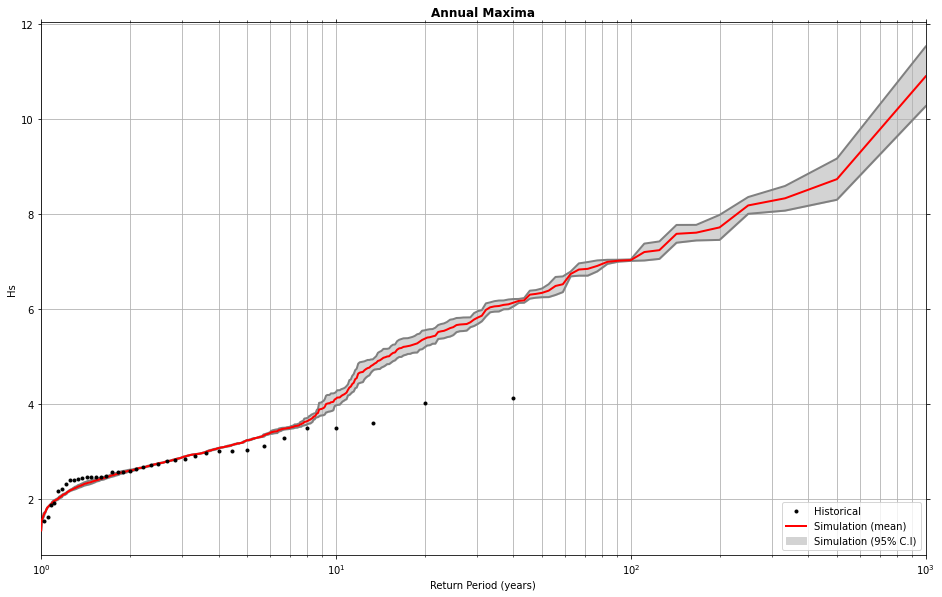

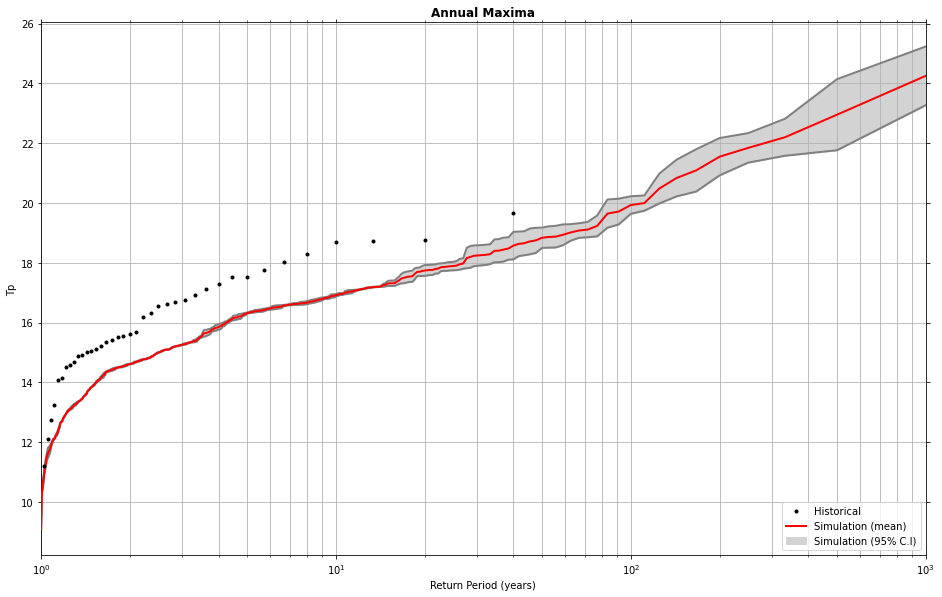

In [10]:
# Hs and Tp Return Period (historical vs. simulations) at AWL Annual Maxima

# Hs at AWL Annual Maxima
Plot_ReturnPeriodValidation(hist_AMax['Hs'], sim_AMax['Hs'].transpose());

# Tp at AWL Annual Maxima
Plot_ReturnPeriodValidation(hist_AMax['Tp'], sim_AMax['Tp'].transpose());



## AWL - Annual Maxima Probabilistic Plots

In [11]:
# Probabilistic plots parameters

n_clusters_AWT = 6    # number of AWT clusters
n_clusters_DWT = 42   # number of DWT clusters

# Select one simulation DWTs - WAVEs simulation
n_sim = 0
sim_AMax_n = sim_AMax.sel(n_sim=0)


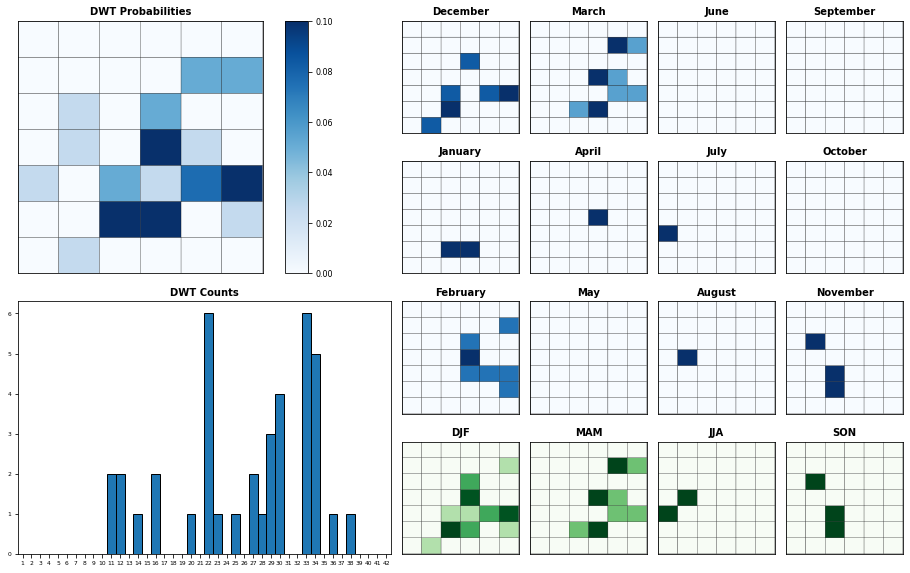

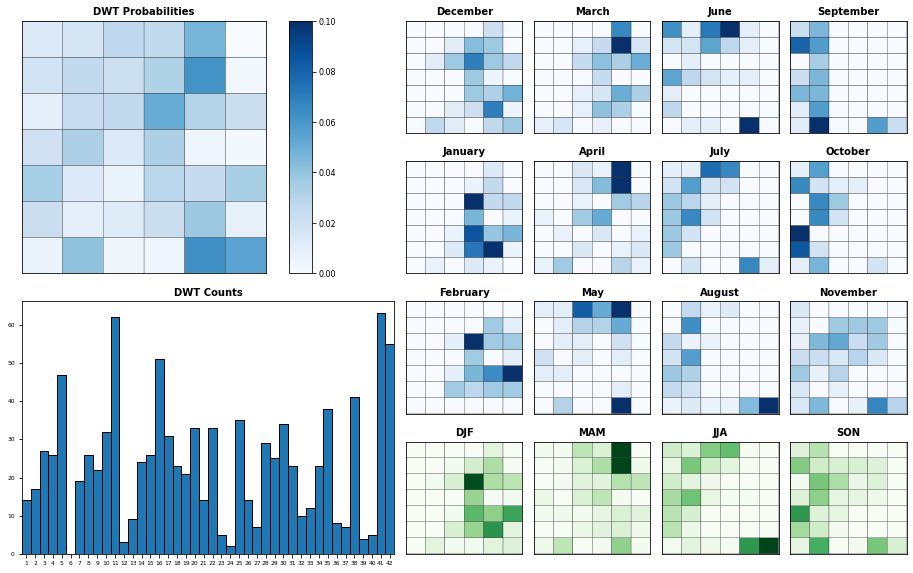

In [12]:
# Plot Annual Maxima DWT probabilities by month

# Historical
Plot_DWTs_Probs(hist_AMax['DWT'].values, hist_AMax.time.values, n_clusters_DWT);

# Simulation
Plot_DWTs_Probs(sim_AMax_n['DWT'].values, sim_AMax_n.time.values, n_clusters_DWT);


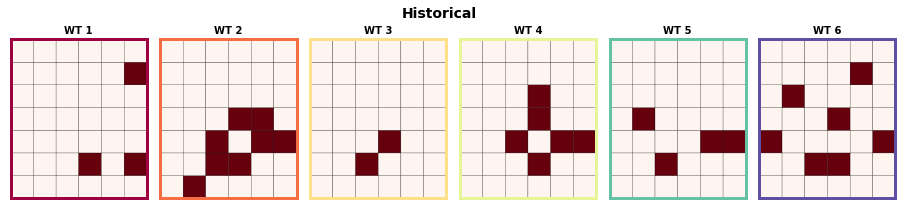

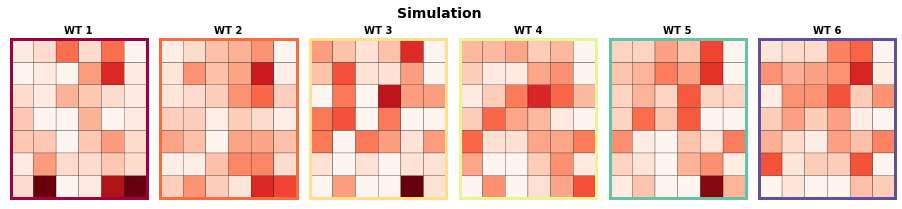

In [13]:
# Plot Annual Maxima AWTs/DWTs Probabilities 

# Historical
Plot_Probs_WT_WT(
    hist_AMax['AWT'].values - 1, hist_AMax['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Historical',
);

# Simulation 
Plot_Probs_WT_WT(
    sim_AMax_n['AWT'].values[:] - 1, sim_AMax_n['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Simulation',
);



## Level Variables (level, AT, MMSL, TWL) - Histograms

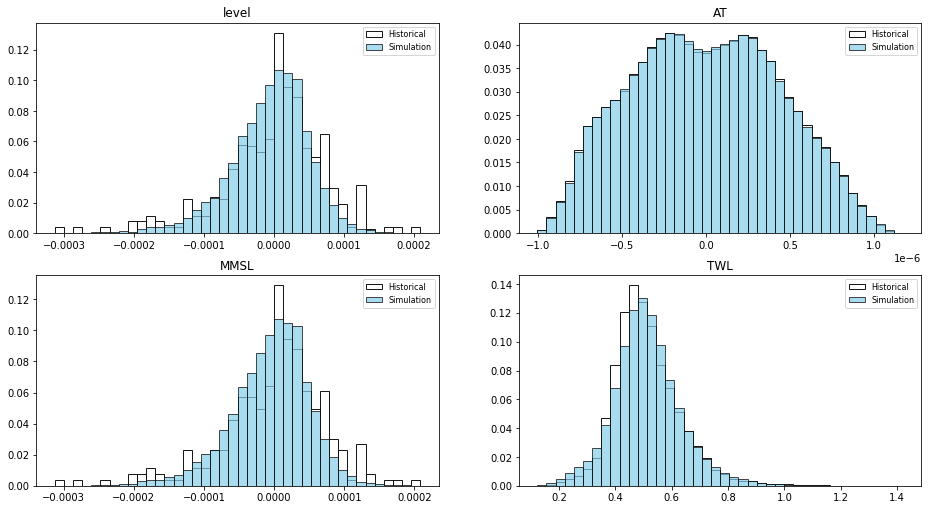

In [17]:

# Plot level, AT, MMSL and TWL histogram comparison between historical and simulated data
Plot_LevelVariables_Histograms(HIST_C_h, SIM_C_h.sel(n_sim = 0));



## TWL - Annual Maxima

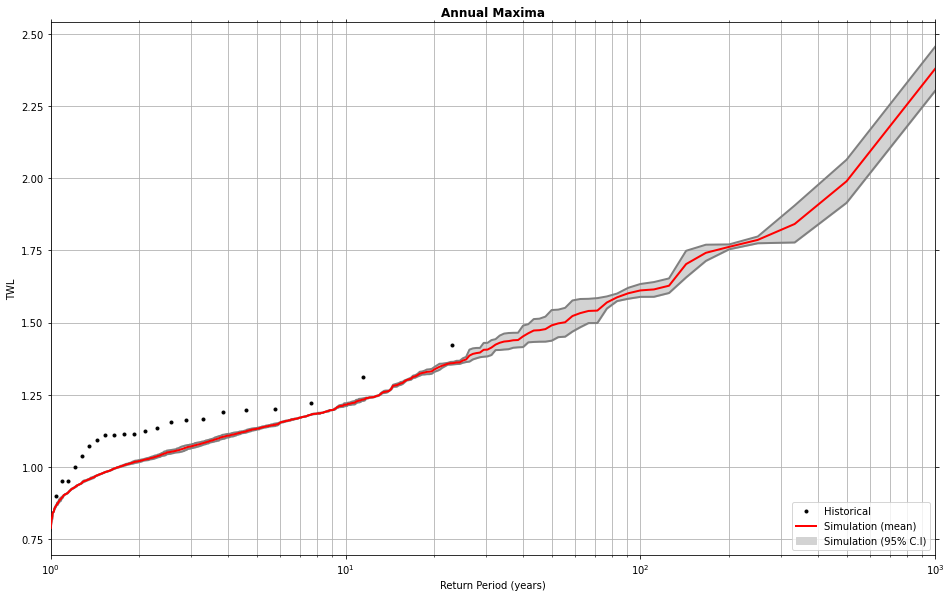

In [18]:
# Plot TWL annual maxima

# calculate Annual Maxima values for historical and simulated data
hist_A = HIST_C_h['TWL'].groupby('time.year').max(dim='time')
sim_A = SIM_C_h['TWL'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A.transpose());
